## From the article

# Implementing a distance-based classifier with a quantum interference circuit

###  M. Schuld et al 2017 EPL 119 60002

# Preparing the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
iris = pd.read_csv("Iris/iris.data",header=None,names=["f0","f1","f2","f3","class"])

In [3]:
setosa = iris[iris["class"] == "Iris-setosa"].loc[:,["f0","f1","class"]]
# setosa.loc[:,"class"] = -1
setosa["color"] = "DarkGreen"

In [4]:
versicolor = iris[iris["class"] == "Iris-versicolor"].loc[:,["f0","f1","class"]]
# versicolor.loc[:,"class"] = 1
versicolor["color"] = "DarkBlue"

In [5]:
virginica = iris[iris["class"] == "Iris-virginica"].loc[:,["f0","f1","class"]]
# virginica.loc[:,"class"] = 1
virginica["color"] = "DarkRed"

In [6]:
data = pd.concat([setosa,versicolor])

In [ ]:
data = pd.concat([versicolor,virginica])

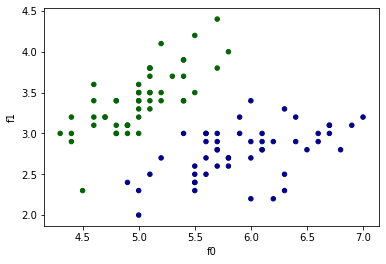

In [8]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [ ]:
# data.mean()
# data["f0"] -= data.mean()[0]
# data["f1"] -= data.mean()[1]

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.loc[:,["f0","f1"]] = scaler.fit_transform(data.loc[:,["f0","f1"]])

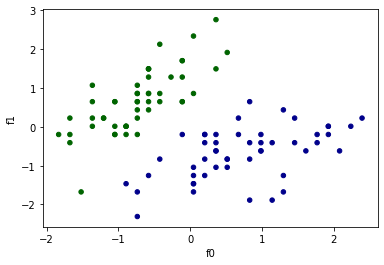

In [10]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [11]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [12]:
for i in data.index:
    v = [data.loc[i,"f0"],data.loc[i,"f1"]]
    v = normalize(v)
    data.loc[i,"f0"], data.loc[i,"f1"] = v[0], v[1]

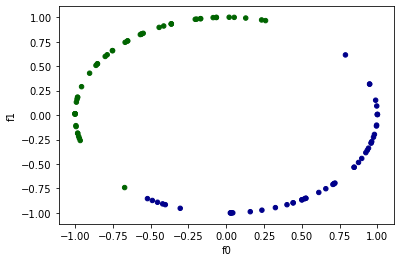

In [13]:
data.plot.scatter(x="f0", y="f1", c=data.color)

In [14]:
# For setosa and versicolor
vectors = data.loc[[33,85,28,36],["f0","f1","class"]]
vectors["label"], vectors["angle"] = ["x0 (t0)","x1 (t1)","x' (x0)","x'' (x1)"], [round(np.pi,3),1.325,4.304,3.036]
vectors

,f0,f1,class,label,angle
33,0.019449,0.999811,Iris-setosa,x0 (t0),3.142
85,0.788610,0.614894,Iris-versicolor,x1 (t1),1.325
28,-0.549104,0.835754,Iris-setosa,x' (x0),4.304
36,0.052917,0.998599,Iris-setosa,x'' (x1),3.036


In [ ]:
# For versicolor and virginica
vectors = data.loc[[50,145,53,149],["f0","f1","class"]]
vectors["label"] = ["t0","t1","x0","x1"]
vectors

In [15]:
f0 = vectors.columns.get_loc("f0")
f1 = vectors.columns.get_loc("f1")

In [16]:
t0 = np.arctan(vectors.iloc[0,f1] / vectors.iloc[0,f0]) * 2 % (2 * np.pi)

In [17]:
t1 = np.arctan(vectors.iloc[1,f1] / vectors.iloc[1,f0]) * 2 % (2 * np.pi)

In [18]:
x0 = np.arctan(vectors.iloc[2,f1] / vectors.iloc[2,f0]) * 2 % (2 * np.pi)

In [19]:
x1 = np.arctan(vectors.iloc[3,f1] / vectors.iloc[3,f0]) * 2 % (2 * np.pi)

# Building the quantum circuit

In [20]:
import qiskit
from qiskit import IBMQ
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram
import qiskit.aqua.circuits.gates.controlled_ry_gates

In [21]:
a = QuantumRegister(1,'a')
m = QuantumRegister(1,'m')
i = QuantumRegister(1,'i')
c = QuantumRegister(1,'c')
b = ClassicalRegister(2, 'bit')
circuit = QuantumCircuit(a,m,i,c,b)

circuit.h(a)
circuit.h(m)

circuit.barrier()

circuit.cry(x0,a[0],i[0])
circuit.x(a)

circuit.barrier()

# circuit.ccx(a,m,i)
circuit.mcry(t0,a[:]+m[:],i[0],None)
circuit.x(m)

circuit.barrier()

circuit.mcry(t1,a[:]+m[:],i[0],None)

circuit.barrier()

circuit.cx(m,c)

circuit.barrier()

circuit.h(a)
circuit.measure(a,b[0])
circuit.measure(c,b[1])

# circuit.draw(output='mpl')


Total counts are: {'10': 2233, '00': 3718, '01': 369, '11': 1872}


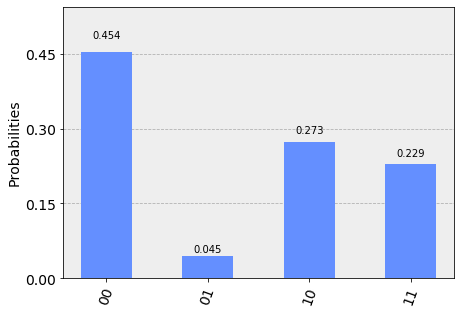

In [22]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=8192)
result = job.result()
counts = result.get_counts(circuit)
print("\nTotal counts are:",counts)
plot_histogram(counts)

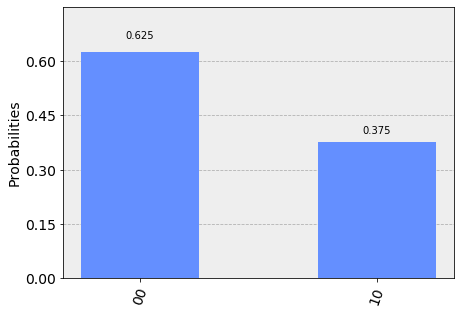

In [23]:
goodCounts = {k: counts[k] for k in counts.keys() & {'00', '10'}}
plot_histogram(goodCounts)